In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import seaborn as sns
import datetime

# machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler
import joblib

# metrics
from sklearn.metrics import r2_score

# custom
from reflectance import plotting, file_ops, optimisation_pipeline, spectrum_utils, ml_utils

# TO DO
- ~~pipeline~~
- ~~full parameter sweep~~
- ~~other models? NN?~~
- ~~feature importance visualisation~~
- ~~Does CCA disappear on grouping?~~ – no, just shifts everything else up
- ~~Test NN – pytorch?~~
- ~~fitting for depth~~
- ~~get uncertainty from RF?~~
- ~~fix plotting shading~~
- ~~visualise by site/depth~~
- ~~better simulation~~
- ~~add synthetic as train data source~~
- ~~emulate S2 from validation spectra~~
- ~~apply ML to wider image(s)~~
- ~~Weibull fit spectra for depth~~ - now binormal
- ~~statistical significance of depth on fit? ANOVA! (just to piss Eric off)~~
- ~~repeated row chunks in validation?~~ – duplication over multiple potential pixels
- ~~try with simulation only~~
- ~~look into Sean's work~~
- ~~compare depths (recorded and predicted) with kbay lidar~~
- ~~book Tora concert~~
- ~~visualise distribution across sites~~
- ~~find sites by spectral matching~~ – doesn't work, spectra are super different
- physical model prediction of depth
- does physical model get worse at extracting benthic ratios with depth
- visualise variance on feature: look into calculation of rolling importance
- check difference between validation v1 and v2
- check performance of other metrics in determining depth
- rank fits by combination of individual fits and depth derivation r2s
- find validation spectra through matching. Fall-back: visualise pixels around apparent sites.
- optimise with parameter distributions and/or with error term
- take surrounding pixels (within homogeneity condition) and plot predictions with error bars
- make my own plotting repo

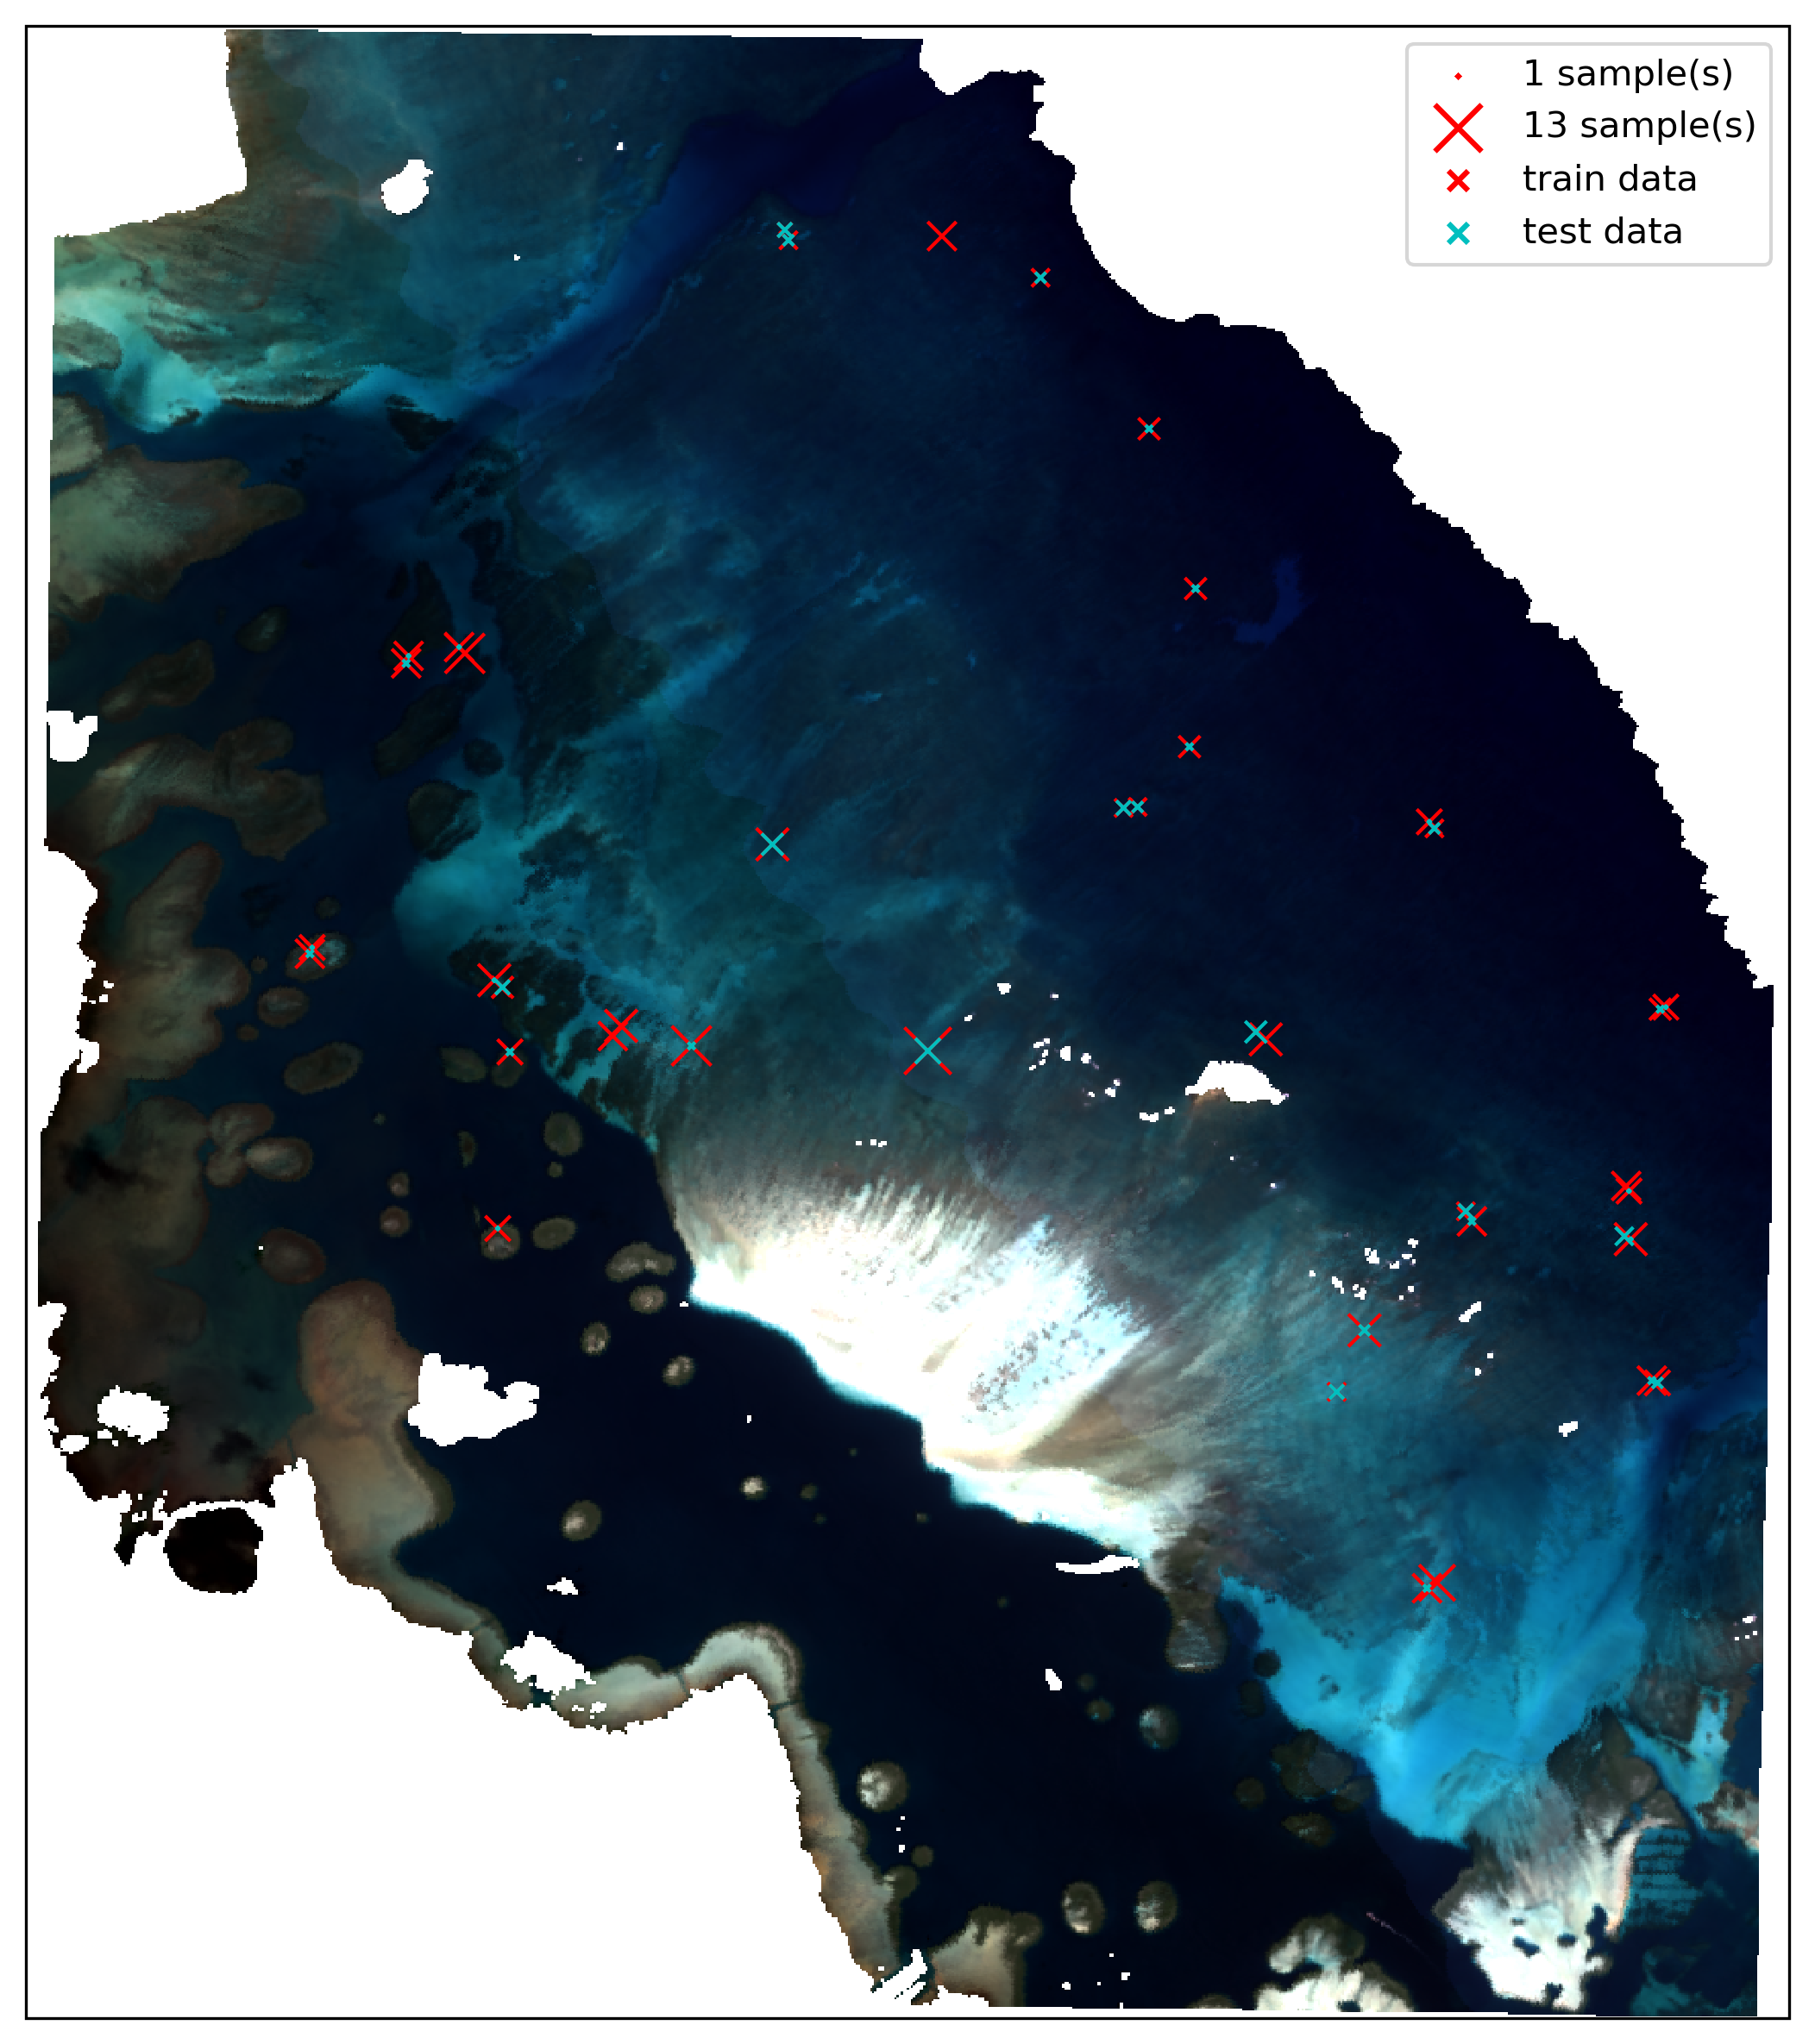

In [2]:
# load labels (recorded benthic cover)
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")
validation_data.head()

X         Y Campaign         Locale  Station      TimeUTC  \
0  145.463908 -14.69196      GBR  Lizard Island      523  9/4/16 0:38   
1  145.463908 -14.69196      GBR  Lizard Island      523  9/4/16 0:38   
2  145.463908 -14.69196      GBR  Lizard Island      523  9/4/16 0:38   
3  145.463908 -14.69196      GBR  Lizard Island      523  9/4/16 0:38   
4  145.463908 -14.69196      GBR  Lizard Island      523  9/4/16 0:38   

      TimeLocal  Depth Metabolism Optics  ... othInvert  othOther  othSponge  \
0  9/4/16 10:38    1.6        NaN    NaN  ...         0         0          0   
1  9/4/16 10:38    1.6        NaN    NaN  ...         0         0          0   
2  9/4/16 10:38    1.6        NaN    NaN  ...         0         0          0   
3  9/4/16 10:38    1.6        NaN    NaN  ...         0         0          0   
4  9/4/16 10:38    1.6        NaN    NaN  ...         0         0          0   

   othUrchin  sedLimest  sedMud  sedRubble  sedSand  ROInumber  \
0          0          0       0          0       27          1   
1          0          0       0          0       27          1   
2          0          0       0          0       27          1   
3          0          0       0          0       27          1   
4          0          0       0          0       27          1   

                         Flightline  
0  prm20160908t225710_corr_v1w2_img  
1  prm20160908t225710_corr_v1w2_img  
2  prm20160908t225710_corr_v1w2_img  
3  prm20160908t225710_corr_v1w2_img  
4  prm20160908t225710_corr_v1w2_img  

[5 rows x 34 columns]

In [3]:
(X_train, X_test), (y_train, y_test), labels = ml_utils.MLDataPipe(
    endmember_class_schema="three_endmember", target="depth", data_source="prism_fits").generate_data()
print("N train samples:", X_train.shape[0])
print("N features:", X_train.shape[1])
print("N test samples:", X_test.shape[0])
print("Label dimensions:", y_train.shape[1])

N train samples: 3100
N features: 84
N test samples: 388
Label dimensions: 1


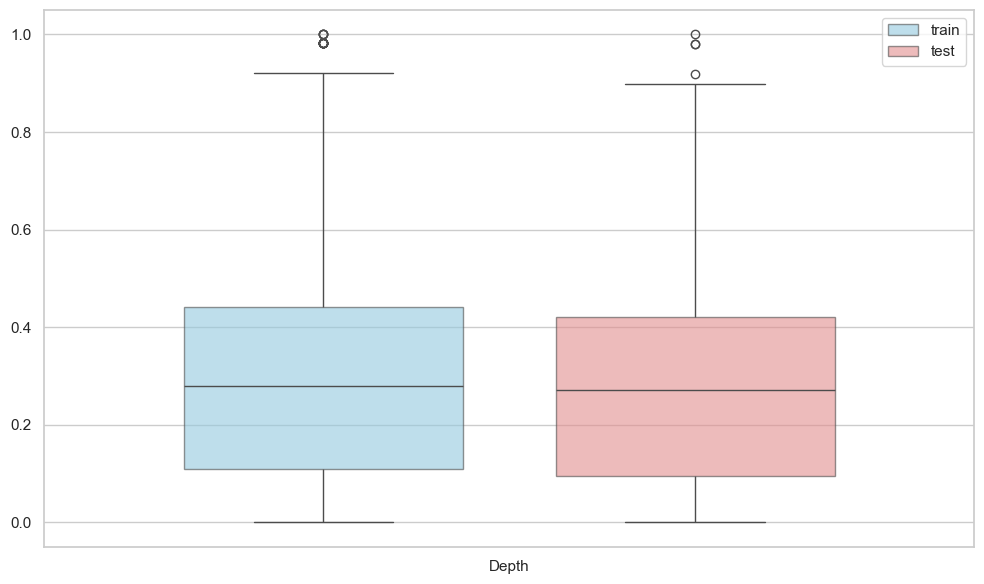

In [4]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data=y_train, ax=ax, positions=np.arange(len(y_train.columns)) - 0.2, width=0.3, color="skyblue", boxprops=dict(alpha=0.6), label="train")
sns.boxplot(data=y_test, ax=ax, positions=np.arange(len(y_test.columns)) + 0.2, width=0.3, color="lightcoral", boxprops=dict(alpha=0.6), label="test")

plt.legend()
plt.tight_layout()

In [5]:
validation_data["Locale"] == "Kaneohe Bay"

0       False
1       False
2       False
3       False
4       False
        ...  
1933    False
1934    False
1935    False
1936    False
1937    False
Name: Locale, Length: 1938, dtype: bool

In [6]:
# exclude KBay from training
kbay_inds = validation_data[validation_data["Locale"] == "Kaneohe Bay"].index
# drop rows intersecting with kbay_inds from X_train
X_train = X_train.drop(kbay_inds.intersection(X_train.index))
y_train = y_train.drop(kbay_inds.intersection(y_train.index))
X_train.shape

(2460, 84)

In [16]:
save_models = False
# best_rf = ml_utils.sklModels(model_type="random_forest", n_iter_search=500).return_fitted_model(X_train, y_train)
# best_gbr = ml_utils.sklModels(model_type="gradient_boosting", n_iter_search=5000).return_fitted_model(X_train, y_train)
# best_mlp = ml_utils.sklModels(model_type="mlp", n_iter_search=500).return_fitted_model(X_train, y_train)

if save_models:
    # make directory
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    current_models_dir = file_ops.get_dir(file_ops.MODELS_DIR_FP / timestamp)

    # joblib.dump(best_gbr, current_models_dir / "best_gbr.pkl")
    # joblib.dump(best_rf, current_models_dir / "best_rf_depth.pkl")
    joblib.dump(best_mlp, current_models_dir / "best_mlp_depth_no_kaneohe.pkl")

In [17]:
# predict
# fitted_rf = best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"R^2 for RandomForest: {r2_rf:.3f}")

# y_pred_gbr = best_gbr.predict(X_test)
# r2_gbr = r2_score(y_test, y_pred_gbr)
# print(f"R^2 for MultiOutputGradientBoosted: {r2_gbr:.3f}")

# y_pred_mlp = best_mlp.predict(X_test)
# r2_mlp = r2_score(y_test, y_pred_mlp)
# print(f"R^2 for MLP: {r2_mlp:.3f}")

R^2 for RandomForest: 0.724


In [18]:

test_data = y_test
pred_data = y_pred_rf

metadata = spectrum_utils.generate_model_metadata(validation_data, best_rf, y_test)
# metadata = validation_data.loc[y_test.index, ["Locale", "Depth"]]


In [19]:
# # Combine test_data and pred_data in a multiindex dataframe
# data_multiindex = pd.MultiIndex.from_product([["true", "pred"], labels.columns], names=["source", "label"])
# combined_data = np.hstack([test_data, pred_data])
# data_df = pd.DataFrame(combined_data, index=y_test.index, columns=data_multiindex)

# # Concatenate data_df and metadata_df
# results_df = pd.concat([data_df, metadata_df], axis=1)
# results_df

In [20]:
test_data = y_test
pred_data = y_pred_mlp

# plotting.plot_regression_results(test_data, pred_data, labels, metadata=metadata, color_by="Depth")

NameError: name 'y_pred_mlp' is not defined

In [54]:
y_test_depth

algae     coral  sand
582    0.28  0.289157  0.48
901    0.53  0.566265  0.00
907    0.57  0.506024  0.01
1754   0.53  0.554217  0.00
1464   0.83  0.096386  0.09
...     ...       ...   ...
1914   0.59  0.457831  0.03
1639   0.71  0.000000  0.29
1263   0.78  0.265060  0.00
530    0.15  0.506024  0.43
192    0.92  0.024096  0.05

[388 rows x 3 columns]

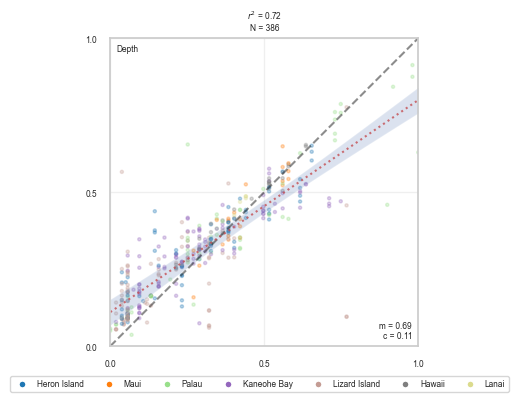

In [60]:
# scale depth data

(X_train, _), (_, y_test_depth), labels = ml_utils.MLDataPipe(
    endmember_class_schema="three_endmember", target="depth", data_source="prism_fits").generate_data()

test_data = y_test_depth
pred_data = y_pred_rf

fig, axes = plt.subplots(1, 1, figsize=(4, 4))
plotting.plot_regression_axis(fig, axes, test_data, pred_data, labels, 
                              metadata=metadata,
                              color_by="Locale")

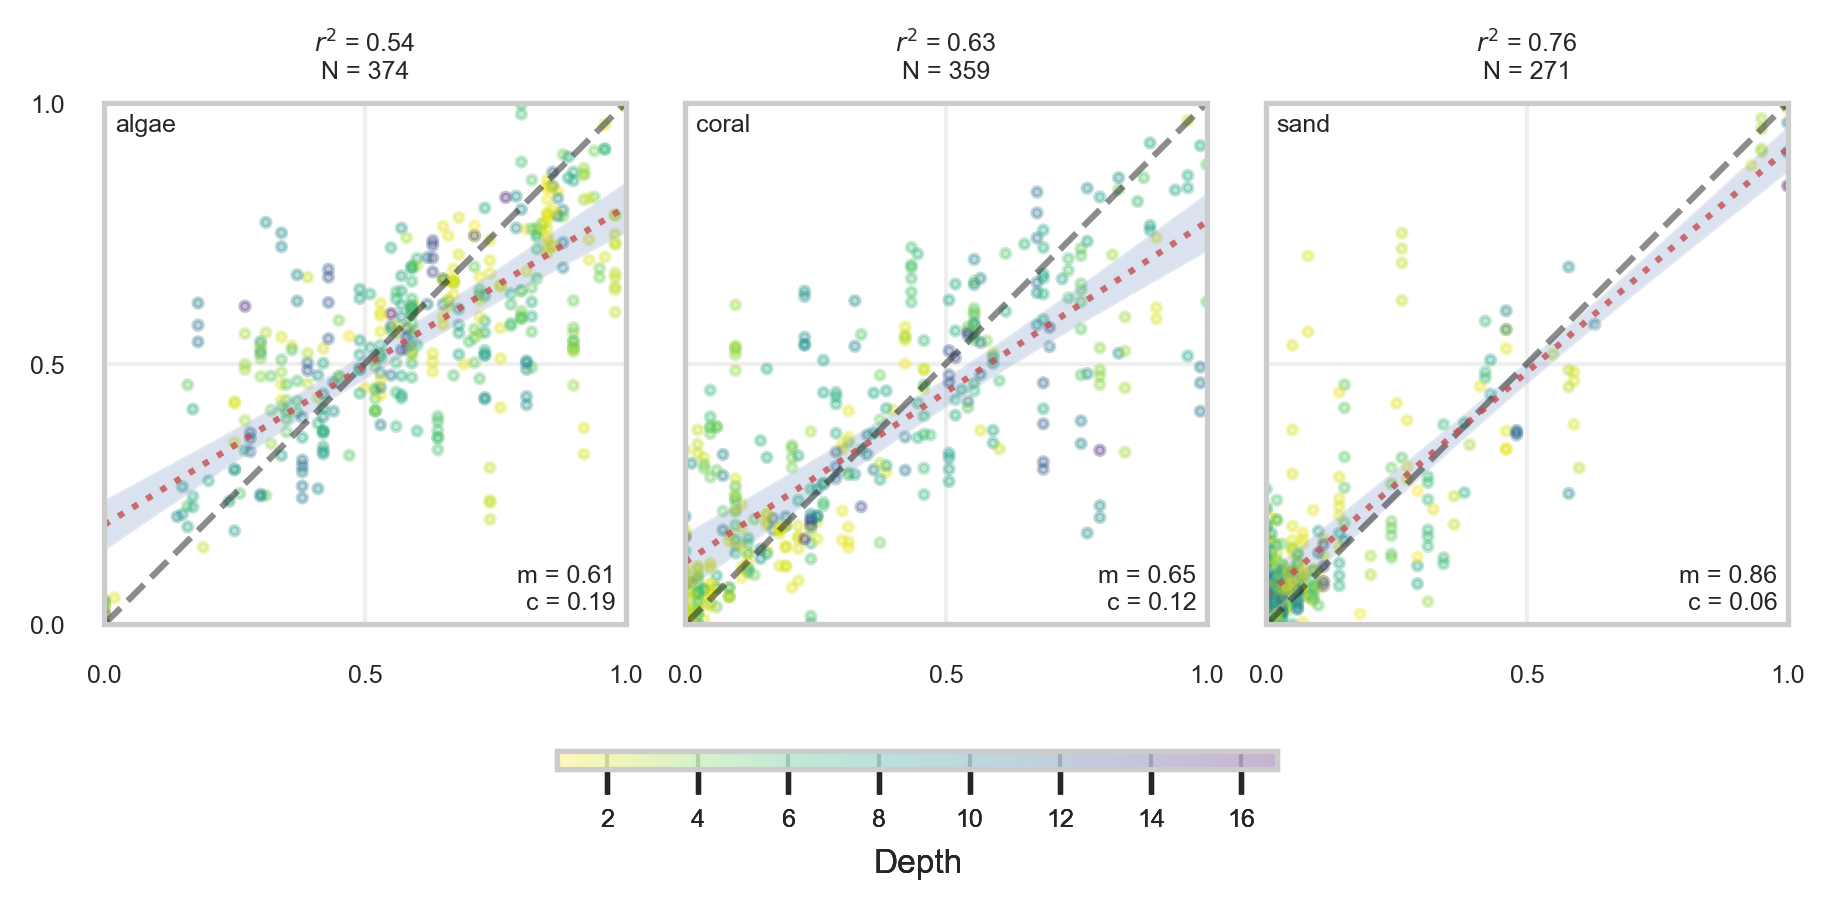

In [44]:
(X_train, _), (_, y_test_benthic), labels = ml_utils.MLDataPipe(
    endmember_class_schema="three_endmember", target="endmember", data_source="prism_fits").generate_data()

test_data = y_test_benthic
pred_data = np.clip(joblib.load(file_ops.MODELS_DIR_FP / "20241003-164331/best_benthic_mlp_no_kaneohe.pkl").predict(X_test), 0, 1)

plotting.plot_regression_results(test_data, pred_data, test_data,
                                 metadata=metadata,
                                 color_by="Depth")

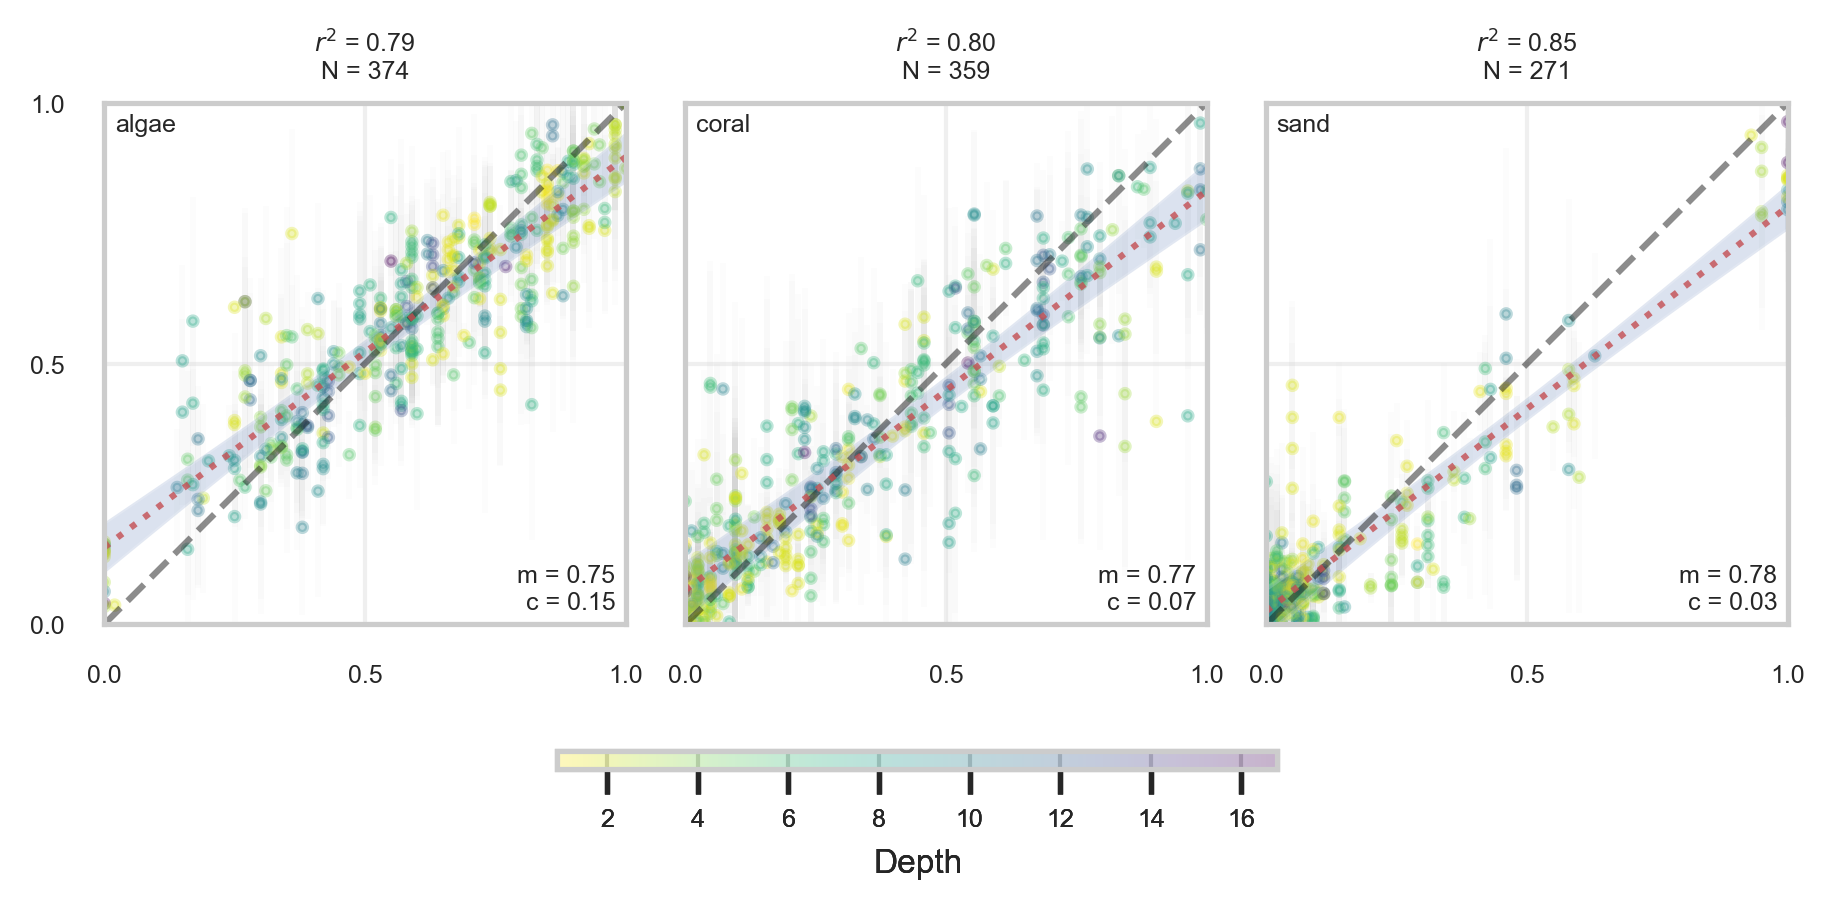

In [78]:
test_data = y_test
pred_data = y_pred_mlp

plotting.plot_regression_results(test_data, pred_data, labels,
                                 metadata=metadata, 
                                 color_by="Depth")

In [94]:
errors_df = test_data - pred_data
# errors_df["Depth"] = metadata["Depth"]


In [98]:
from scipy.stats import pearsonr, spearmanr

# for each label, run a statistical test to see dependence on depth
correlation_results = {}

# Loop through each target and compute the correlation with depth
for target in errors_df.columns:
    # Pearson correlation
    pearson_corr, pearson_p = pearsonr(metadata["Depth"], errors_df[target])
    
    # Spearman correlation (alternative to Pearson if you prefer a rank-based test)
    spearman_corr, spearman_p = spearmanr(metadata["Depth"], errors_df[target])
    
    # Store the results in a dictionary
    correlation_results[target] = {
        'Pearson Correlation': pearson_corr,
        'Pearson p-value': pearson_p,
        'Spearman Correlation': spearman_corr,
        'Spearman p-value': spearman_p
    }

correlation_df = pd.DataFrame(correlation_results).T
correlation_df


Pearson Correlation  Pearson p-value  Spearman Correlation  \
algae            -0.127788         0.011757             -0.122643   
coral             0.049309         0.332679              0.105318   
sand              0.117922         0.020157              0.082346   
Depth             1.000000         0.000000              1.000000   

       Spearman p-value  
algae          0.015644  
coral          0.038117  
sand           0.105331  
Depth          0.000000

In [193]:
# test the statistical significance on depth on the accuracy of the model
import statsmodels.api as sm

# calculate error for each class
error = test_data - pred_data
error_df = pd.DataFrame(error, columns=labels.columns)
error_df["Depth"] = metadata["Depth"]
error_df = error_df.melt(id_vars="Depth", var_name="label", value_name="error")
error_df['intercept'] = 1

error_df

Depth  label     error  intercept
0      11.3  algae -0.268383          1
1      10.1  algae -0.072241          1
2       7.6  algae  0.130832          1
3       6.1  algae  0.072937          1
4       5.8  algae  0.038203          1
...     ...    ...       ...        ...
1159    2.0   sand -0.037806          1
1160    0.9   sand  0.162448          1
1161    5.5   sand -0.071375          1
1162    7.9   sand -0.021844          1
1163    3.4   sand -0.022008          1

[1164 rows x 4 columns]

In [195]:
# Fit the regression model
model = sm.OLS(error_df['error'], error_df[['intercept', 'Depth']]).fit()
print(model.summary())

# ANOVA
from statsmodels.formula.api import ols
model = ols("error ~ Depth", data=error_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.03058
Date:                Mon, 30 Sep 2024   Prob (F-statistic):              0.861
Time:                        15:18:04   Log-Likelihood:                 636.75
No. Observations:                1164   AIC:                            -1270.
Df Residuals:                    1162   BIC:                            -1259.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0022      0.008     -0.274      0.7

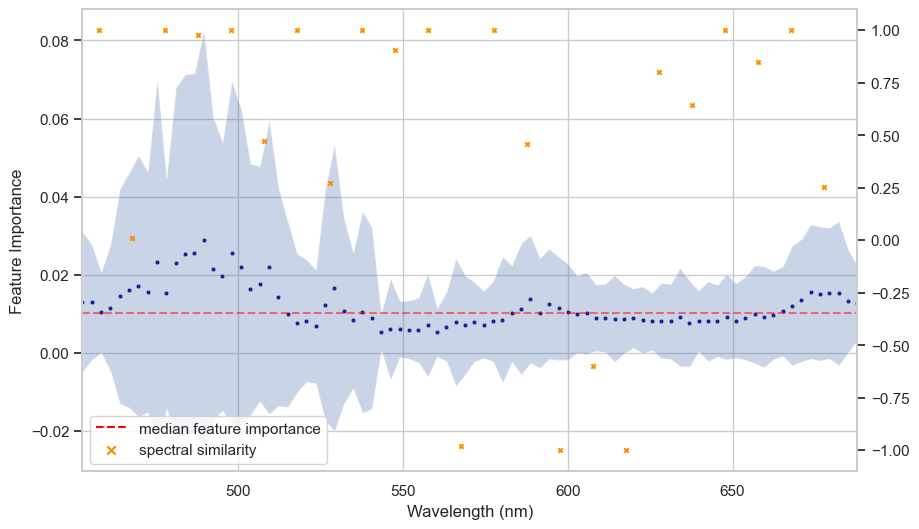

In [526]:
# plot a scatterplot of mean importance, with std shaded
rf_importances = np.array([tree.feature_importances_ for tree in best_rf.estimators_])
importance_df = pd.DataFrame(rf_importances, columns=X_train.columns).agg(["mean", "std"]).T

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=importance_df.index, y=importance_df["mean"], s=10, ax=ax, color="darkblue")
ax.fill_between(importance_df.index, importance_df["mean"] - importance_df["std"], importance_df["mean"] + importance_df["std"], alpha=0.3)

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Feature Importance")
ax.set_xlim(min(importance_df.index), max(importance_df.index))
ax.hlines(np.median(importance_df["mean"]), min(importance_df.index), max(importance_df.index), linestyle="--", alpha=0.5, color="red")

kernel_width = 10
kernel_displacement = 10
ax_metric = ax.twinx()
wv_pairs, (mean_corrs, std_corrs) = spectrum_utils.calc_rolling_similarity(X_train.columns, X_test.values[:2,:], kernel_width, kernel_displacement, spectrum_utils.calc_spectral_similarity_gradient)
ax_metric.scatter([np.mean(pair) for pair in wv_pairs], mean_corrs, s=10, c="darkorange", marker="x", zorder=-100)
ax_metric.grid(False)

ax_metric.plot([],[],linestyle="--", color="red", label="median feature importance")
ax_metric.scatter([],[], color="darkorange", label="spectral similarity", marker="x")

ax_metric.legend()

# Performance comparison with S2

In [53]:
(X_train_s2, X_test_s2), (y_train, y_test), labels = ml_utils.MLDataPipe(
    endmember_class_schema="three_endmember", target="depth", data_source="prism_fits", emulation_source="S2").generate_data()
print("N train samples:", X_train.shape[0])
print("N features:", X_train.shape[1])
print("N test samples:", X_test.shape[0])
print("Label dimensions:", y_train.shape[1])

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


N train samples: 3100
N features: 3
N test samples: 388
Label dimensions: 1


In [54]:
# cast hs to s2

save_models = False
best_rf = ml_utils.sklModels(model_type="random_forest", n_iter_search=500).return_fitted_model(X_train_s2, y_train)
# best_gbr = ml_utils.sklModels(model_type="gradient_boosting", n_iter_search=5000).return_fitted_model(X_train, y_train)
# best_mlp = ml_utils.sklModels(model_type="mlp", n_iter_search=500).return_fitted_model(X_train, y_train)

if save_models:
    # make directory
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    current_models_dir = file_ops.get_dir(file_ops.MODELS_DIR_FP / timestamp)

    # joblib.dump(best_gbr, current_models_dir / "best_gbr.pkl")
    # joblib.dump(best_rf, current_models_dir / "best_rf_depth.pkl")
    joblib.dump(best_mlp, current_models_dir / "best_mlp_depth_no_kaneohe.pkl")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

[CV] END bootstrap=False, max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=130; total time=   0.4s
[CV] END bootstrap=False, max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=130; total time=   0.4s
[CV] END bootstrap=False, max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=130; total time=   0.4s
[CV] END bootstrap=False, max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=130; total time=   0.4s
[CV] END bootstrap=False, max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=130; total time=   0.4s
[CV] END bootstrap=False, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=130; total time=   0.4s
[CV] END bootstrap=False, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=130; total time=   0.4s
[CV] END bootstrap=False, max_depth=1

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV took 196.13 seconds for 500 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.620 (std: 0.025)
Parameters: {'n_estimators': 230, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': True}
Model with rank: 2
Mean validation score: 0.620 (std: 0.027)
Parameters: {'n_estimators': 130, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 100, 'bootstrap': True}
Model with rank: 3
Mean validation score: 0.620 (std: 0.023)
Parameters: {'n_estimators': 130, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}


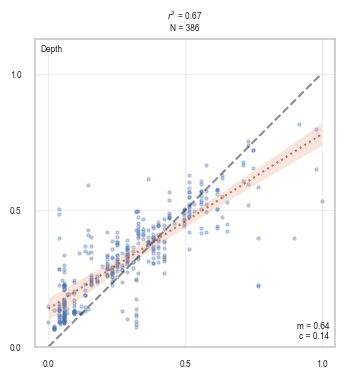

In [56]:
# scale depth data

test_data = y_test
pred_data = best_rf.predict(X_test_s2)

fig, axes = plt.subplots(1, 1, figsize=(4, 4))
plotting.plot_regression_axis(fig, axes, test_data, pred_data, labels, 
                            #   metadata=metadata,
                              color_by="Locale")

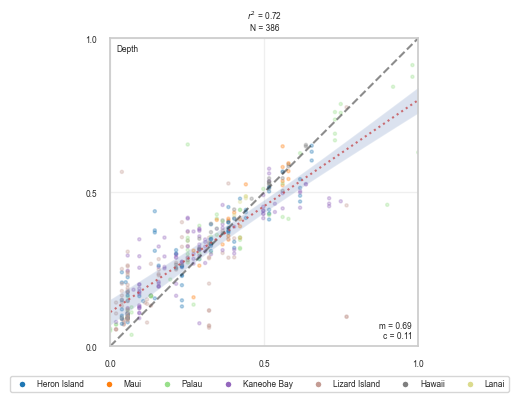

In [64]:
X_train_s2_benthic

B2        B3        B4
582   0.075023  0.101470  0.142836
901   0.052548  0.033241  0.088745
907   0.061395  0.071301  0.088226
1754  0.100771  0.171740  0.179594
1464  0.064346  0.089503  0.108316
...        ...       ...       ...
1914  0.111633  0.185396  0.120208
1639  0.247358  0.366236  0.313605
1263  0.072843  0.120882  0.144854
530   0.069518  0.085933  0.163257
192   0.056873  0.066237  0.103642

[388 rows x 3 columns]

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - to python to disable frozen modules.
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=230; total time=   0.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=230; total time=   0.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=230; total time=   0.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=230; total time=   0.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=230; total time=   0.7s
[CV] END bootstrap=False, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=230; total time=   0.7s
[CV] END bootstrap=False, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=230; total time=   0.7s
[CV] END bootstrap=False, max_depth=60, max_fe

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   0.8s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   0.8s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   0.8s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   0.9s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=130; total time=   0.6s
[CV] END bootstrap=False, max_depth=90, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=180; total time=   0.7s
[CV] END bootstrap=False, max_dept

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=False, max_depth=90, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130; total time=   1.0s
[CV] END bootstrap=False, max_depth=90, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=180; total time=   0.7s
[CV] END bootstrap=True, max_depth=70, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=   0.4s
[CV] END bootstrap=True, max_depth=70, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=   0.4s
[CV] END bootstrap=False, max_depth=90, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=180; total time=   0.7s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_fe

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time=   0.5s
[CV] END bootstrap=False, max_depth=90, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=180; total time=   0.6s
[CV] END bootstrap=False, max_depth=90, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=180; total time=   0.6s
[CV] END bootstrap=False, max_depth=90, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=180; total time=   0.7s
[CV] END bootstrap=False, max_depth=90, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=180; total time=   0.7s
[CV] END bootstrap=False, max_depth=90, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=180; total time=   0.7s
[CV] END bootstrap=False, max_depth=100, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=130; total time=   0.9s
[CV] END bootstrap=False, max_dep

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180; total time=   0.7s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180; total time=   0.6s
[CV] END bootstrap=True, max_depth=90, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=180; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180; total time=   0.7s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180; total time=   0.7s
[CV] END bootstrap=False, max_depth=20,

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=180; total time=   0.6s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=180; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=180; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=180; total time=   1.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=130; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=130; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=130; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=230; total time=   1.2s
[CV] END bootstrap=True, max_depth=80, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=230; total time=   1.2s
[CV] END bootstrap=True, max_depth=80, max_fe

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=130; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=130; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=130; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=130; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=130; total time=   0.4s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=230; total time=   0.7s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=230; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, max_fea

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.4s
[CV] END bootstrap=True, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=230; total time=   1.2s
[CV] END bootstrap=True, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=230; total time=   1.2s
[CV] END bootstrap=True, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=230; total time=   1.2s
[CV] END bootstrap=True, max_depth=60, max_f

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=180; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=180; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=180; total time=   0.5s
[CV] END bootstrap=False, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=180; total time=   1.2s


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=180; total time=   0.5s
[CV] END bootstrap=False, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=180; total time=   1.2s
[CV] END bootstrap=False, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=180; total time=   1.3s
[CV] END bootstrap=False, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=180; total time=   1.3s
[CV] END bootstrap=False, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=180; total time=   1.3s
[CV] END bootstrap=False, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time=   0.5s
[CV] END bootstrap=False, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time=   0.5s
[CV] END bootstrap=False, max_depth=11

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=False, max_depth=110, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time=   0.9s
[CV] END bootstrap=False, max_depth=110, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time=   0.9s
[CV] END bootstrap=False, max_depth=110, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time=   0.9s
[CV] END bootstrap=False, max_depth=110, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time=   1.0s
[CV] END bootstrap=False, max_depth=110, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=130; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=130; total time=   0.4s
[CV] END bootstrap=True, max_de

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=180; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=180; total time=   0.9s
[CV] END bootstrap=False, max_depth=70, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   1.7s
[CV] END bootstrap=False, max_depth=70, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   1.8s
[CV] END bootstrap=False, max_depth=70, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   1.7s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=180; total time=   0.9s
[CV] END bootstrap=False, max_depth=70, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   1.8s
[CV] END bootstrap=True, max_depth=30, ma

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=130; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=130; total time=   0.4s
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=180; total time=   0.6s
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=180; total time=   0.6s
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=180; total time=   0.6s
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=180; total time=   0.6s
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=180; total time=   0.6s
[CV] END bootstrap=False, max_depth=1

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=60, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=180; total time=   0.9s
[CV] END bootstrap=True, max_depth=60, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=180; total time=   0.9s
[CV] END bootstrap=True, max_depth=60, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=180; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=230; total time=   0.7s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=230; total time=   0.7s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=230; total time=   0.7s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=230; total time=   0.7s
[CV] END bootstrap=True, max_depth=60, max_featu

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=110, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=230; total time=   1.2s
[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.4s


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=180; total time=   0.6s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=180; total time=   0.6s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=180; total time=   0.6s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=180; total time=   0.6s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=180; total time=   0.6s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=180; total time=   0.6s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   1.7s
[CV] END bootstrap=False, max_depth=5

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=False, max_depth=100, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.8s
[CV] END bootstrap=False, max_depth=100, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.8s
[CV] END bootstrap=False, max_depth=100, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.8s
[CV] END bootstrap=False, max_depth=100, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.8s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.4s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.4s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.4s


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=80, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=180; total time=   0.9s
[CV] END bootstrap=True, max_depth=80, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=180; total time=   0.9s
[CV] END bootstrap=True, max_depth=80, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=180; total time=   0.9s
[CV] END bootstrap=True, max_depth=80, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=180; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=130; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=180; total time=   0.9s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_feat

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=130; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=130; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=130; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=130; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_featu

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=180; total time=   0.6s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=180; total time=   0.7s
[CV] END bootstrap=False, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time=   1.0s
[CV] END bootstrap=False, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time=   1.0s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=180; total time=   0.6s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=180; total time=   0.6s
[CV] END bootstrap=False, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time=   1.1s
[CV] END bootstrap=False, max_depth=

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=180; total time=   0.7s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=180; total time=   0.7s
[CV] END bootstrap=False, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=230; total time=   1.7s
[CV] END bootstrap=False, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=230; total time=   1.8s
[CV] END bootstrap=False, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=230; total time=   1.8s
[CV] END bootstrap=False, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=230; total time=   1.8s
[CV] END bootstrap=False, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=230; total time=   1.8s
[CV] END bootstrap=False, max_depth=60,

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV took 203.82 seconds for 500 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.496 (std: 0.035)
Parameters: {'n_estimators': 230, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
Model with rank: 2
Mean validation score: 0.496 (std: 0.033)
Parameters: {'n_estimators': 180, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
Model with rank: 3
Mean validation score: 0.495 (std: 0.027)
Parameters: {'n_estimators': 230, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}


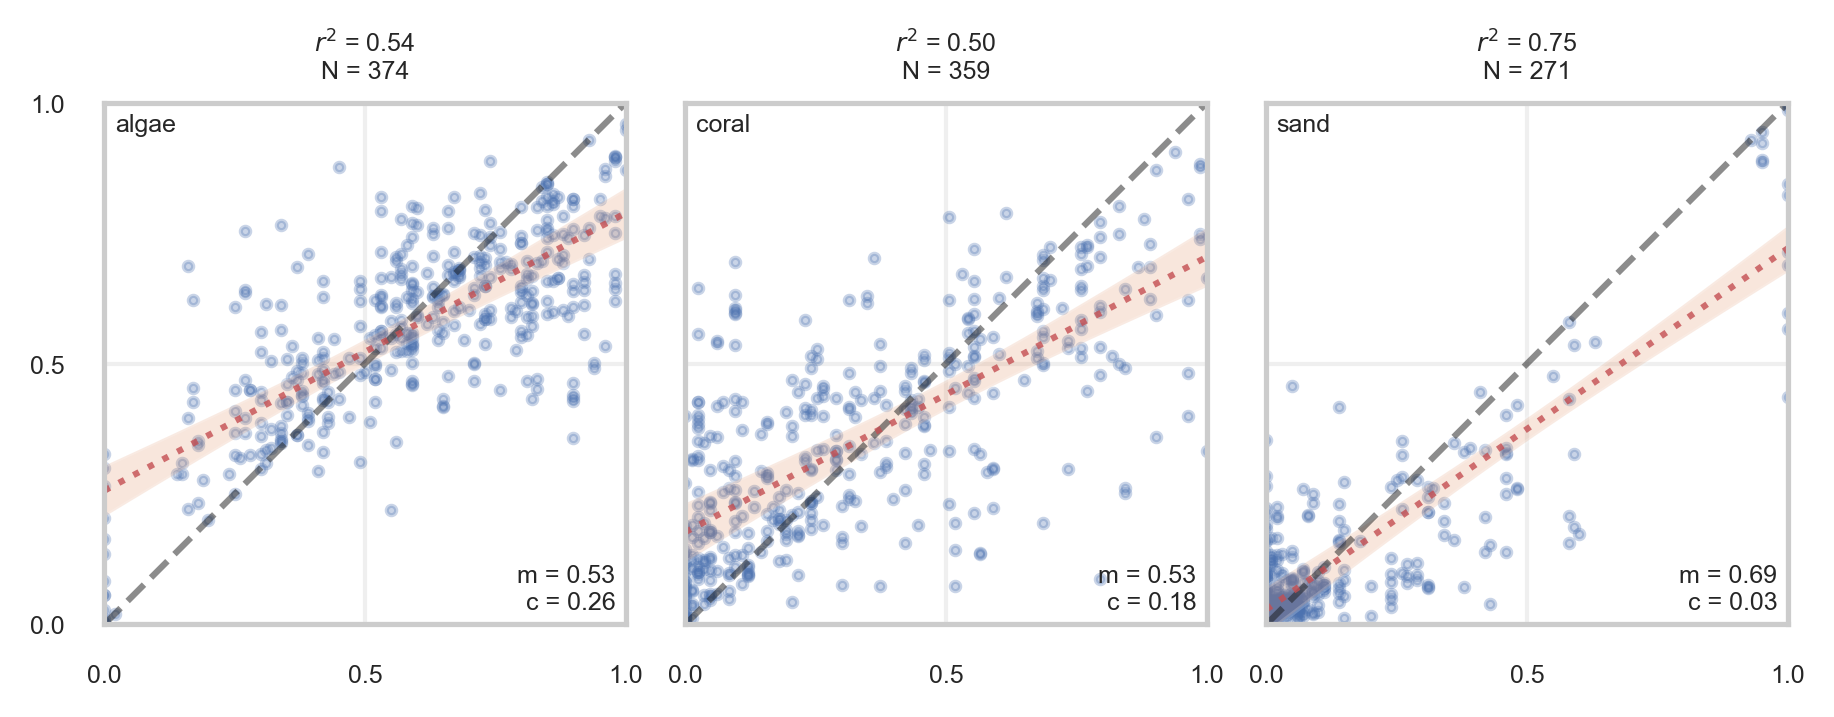

In [65]:
(X_train_s2_benthic, X_test_s2_benthic), (y_train_s2_benthic, y_test_s2_benthic), labels = ml_utils.MLDataPipe(
    endmember_class_schema="three_endmember", target="endmember", data_source="prism_fits", emulation_source="S2").generate_data()

# best_rf_s2_benthic = ml_utils.sklModels(model_type="random_forest", n_iter_search=500).return_fitted_model(X_train_s2_benthic, y_train_s2_benthic)

In [67]:
best_mlp_s2_benthic = ml_utils.sklModels(model_type="mlp", n_iter_search=500).return_fitted_model(X_train_s2_benthic, y_train_s2_benthic)

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 384 is smaller than n_iter=500. Running 384 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, tol=1e-09; total time=   1.0s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, tol=1e-09; total time=   1.5s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam, tol=0.0001; total time=   0.7s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, tol=1e-09; total time=   2.0s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, tol=1e-09; total time=   2.4s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam, tol=0.0001; total time=   1.1s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10, 30, 10

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, tol=1e-09; total time=  51.2s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive, solver=sgd, tol=0.0001; total time=  20.9s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive, solver=adam, tol=0.0001; total time=   3.8s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=sgd, tol=1e-09; total time=  39.1s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive, solver=adam, tol=0.0001; total time=   4.5s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive, solver=adam, tol=0.0001; total time=   3.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive, solver=adam, tol=0.0001; total time=   3.7s
[CV] END activation=

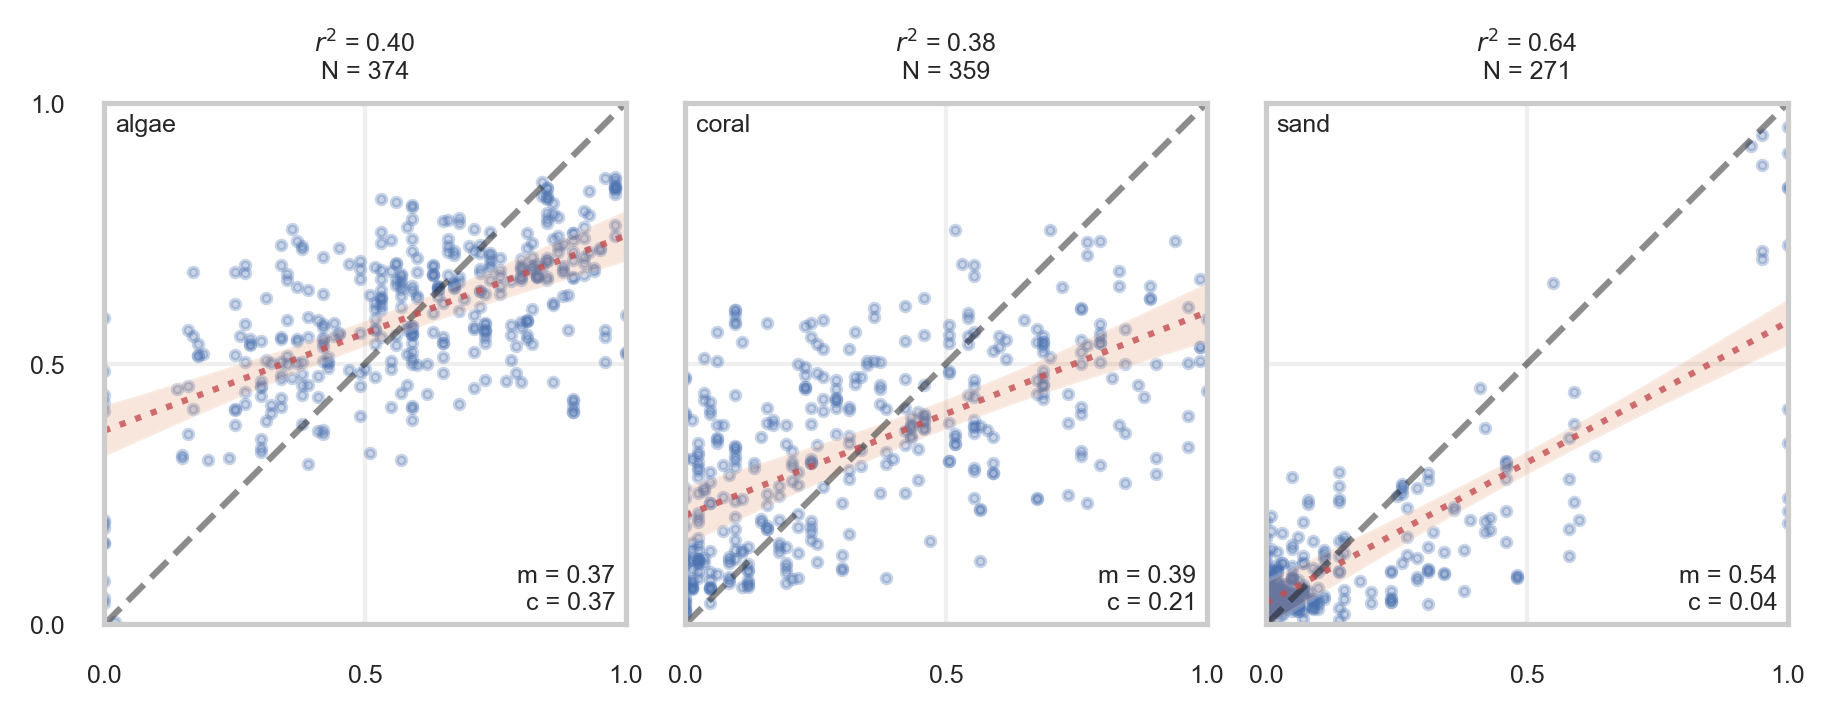

In [68]:
test_data = y_test_s2_benthic
pred_data = best_mlp_s2_benthic.predict(X_test_s2_benthic)

plotting.plot_regression_results(test_data, pred_data, test_data,
                                #  metadata=metadata,
                                 color_by="Depth")

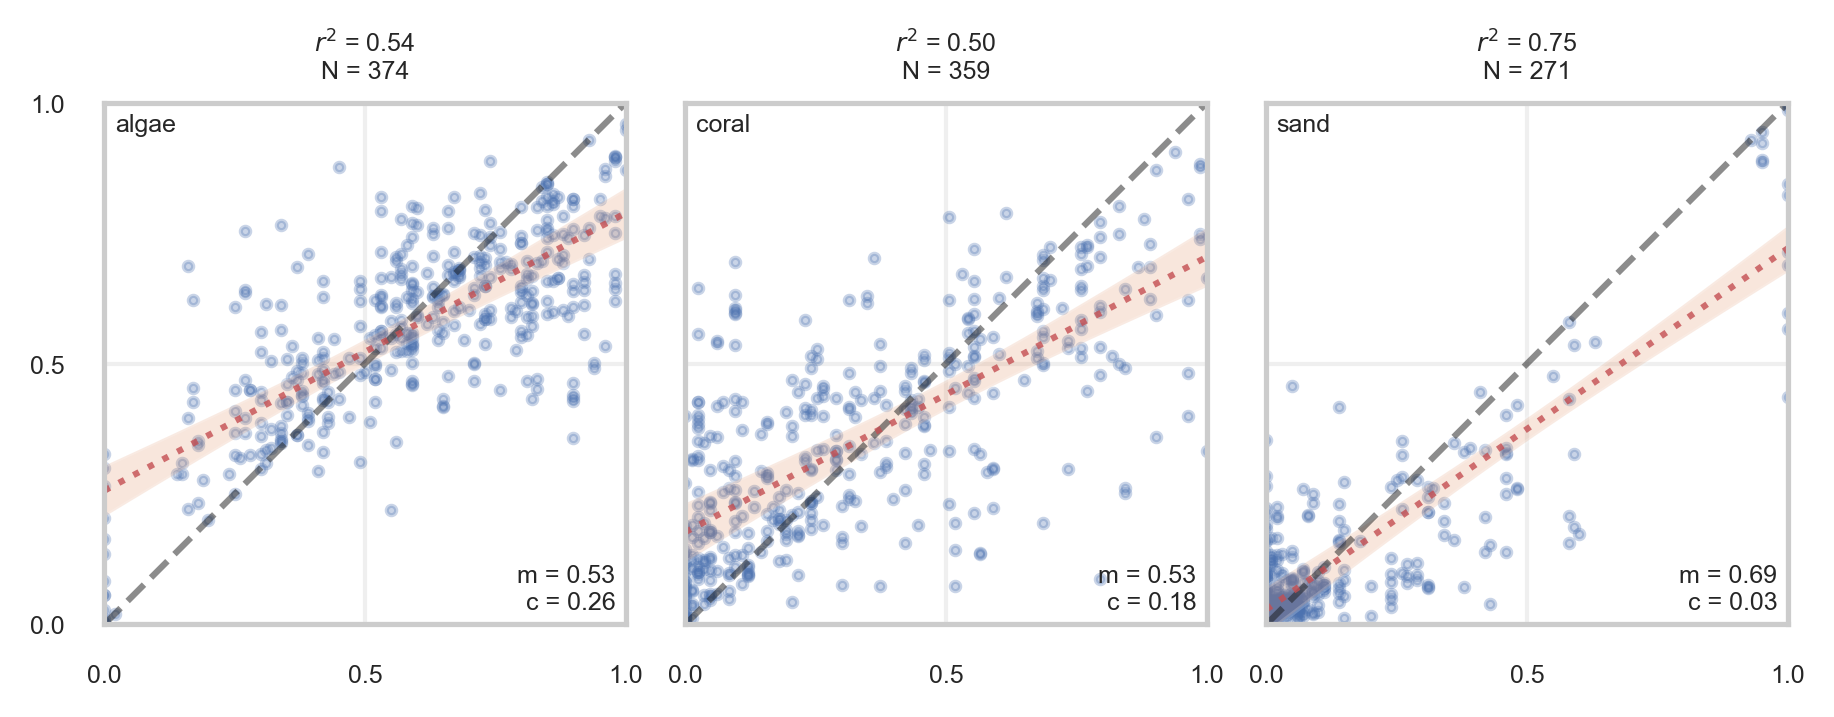

In [66]:
plotting.plot_regression_results(test_data, pred_data, test_data,
                                #  metadata=metadata,
                                 color_by="Depth")

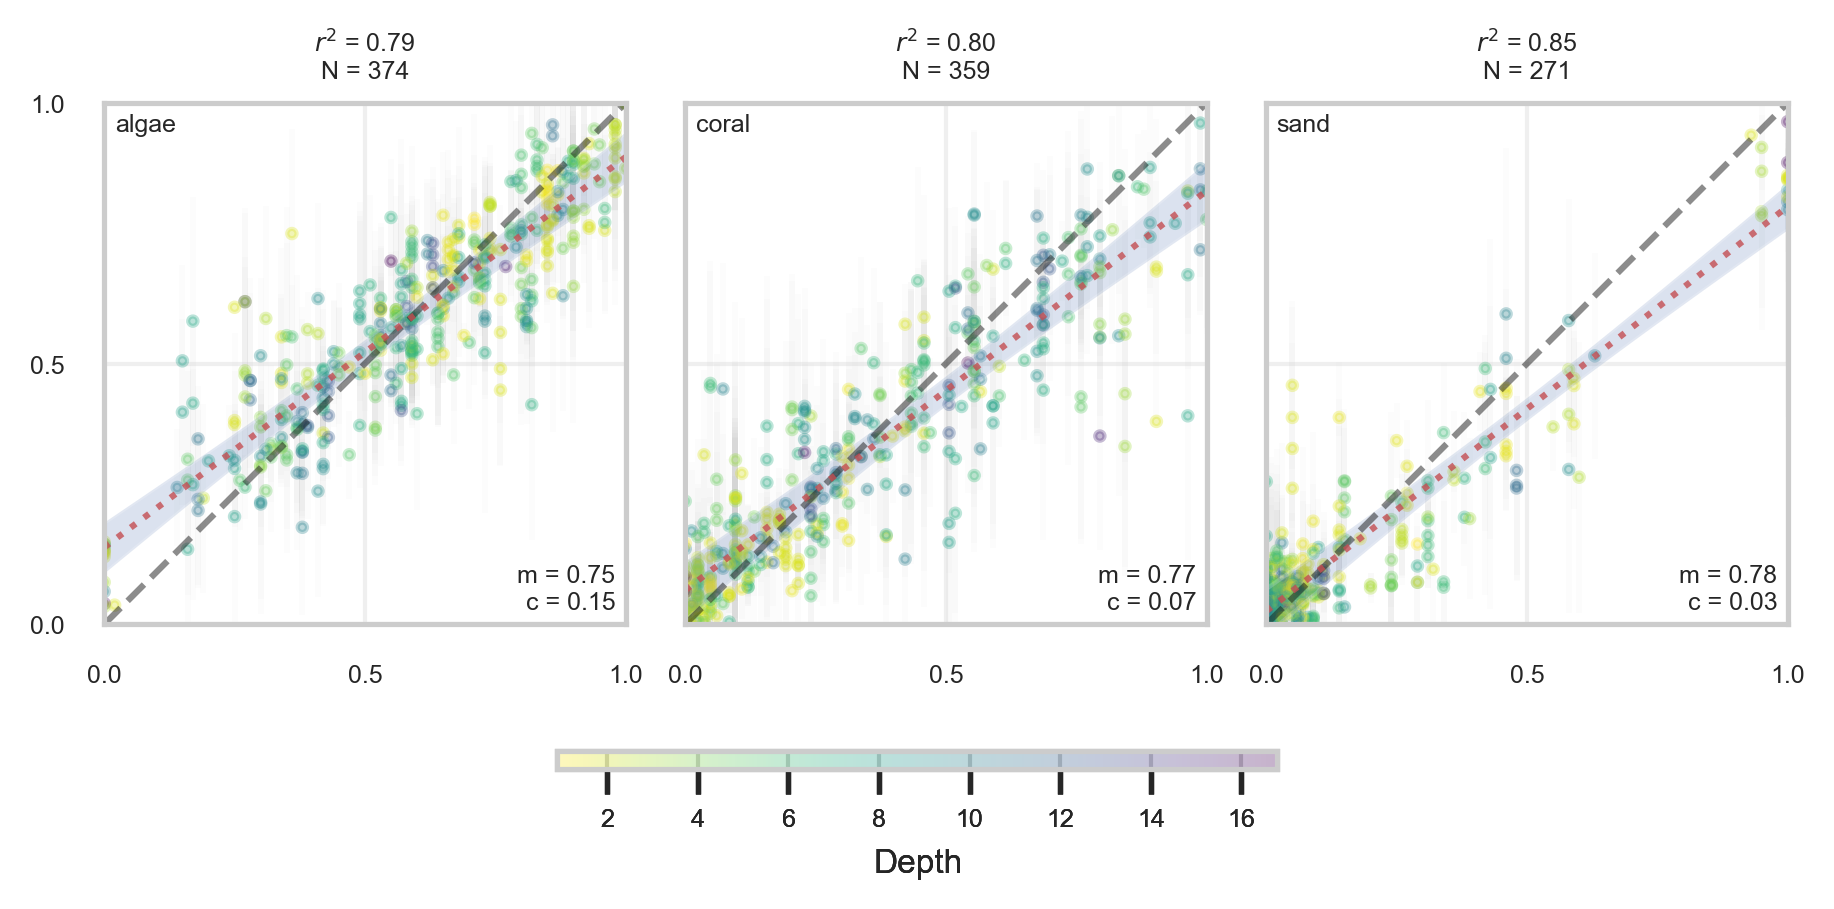

Benthic best rf - hs
 
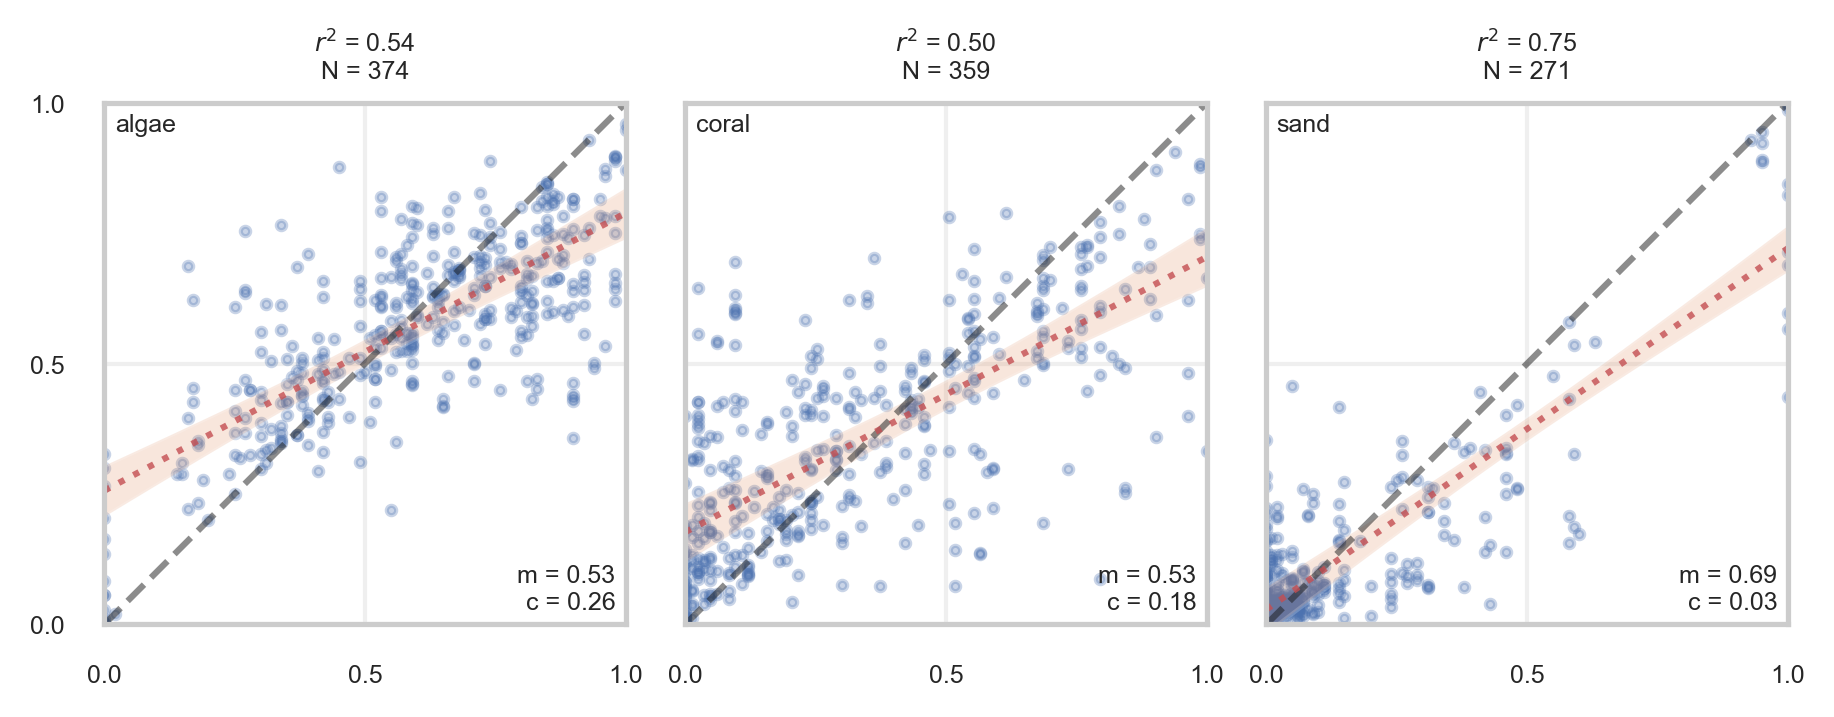

Benthic best rf - s2

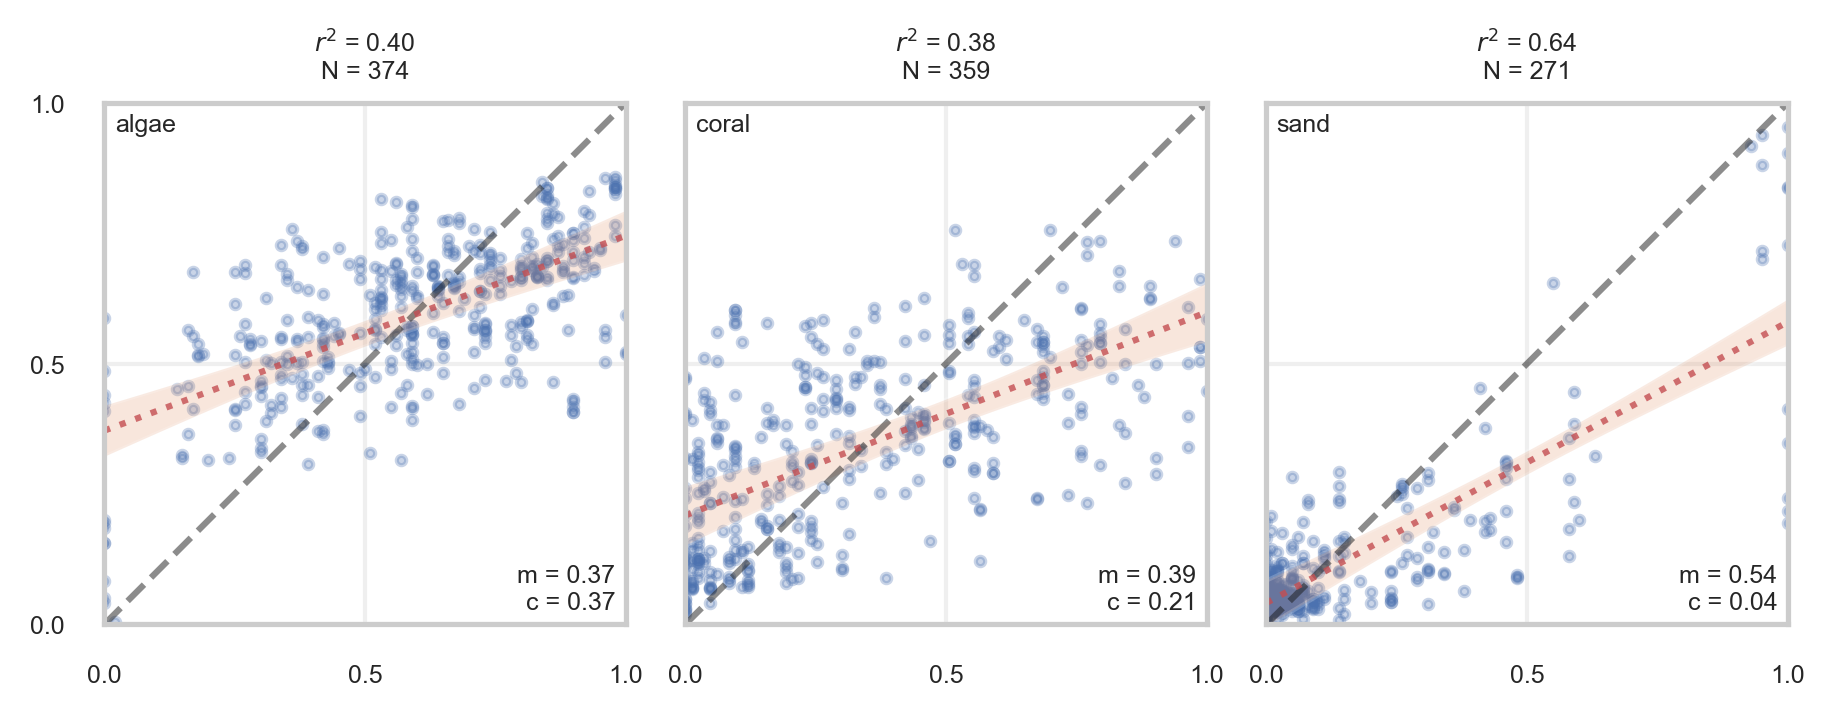

Benthic best mlp - s2




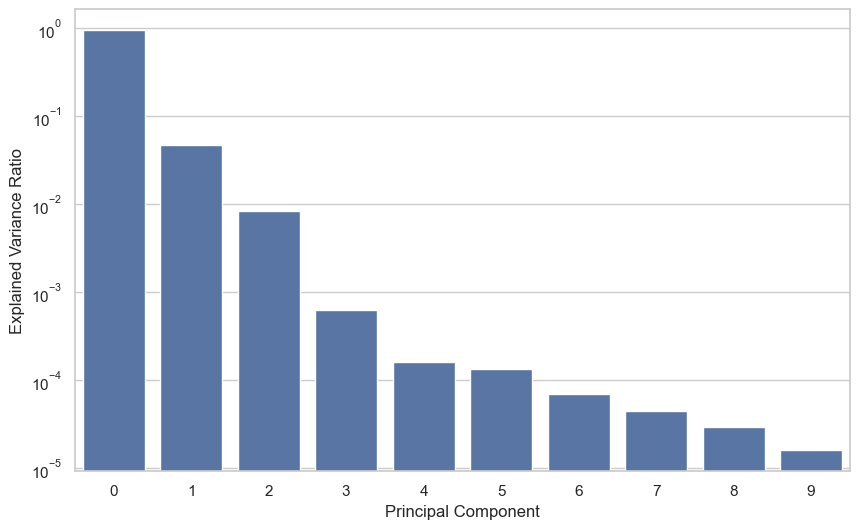

In [71]:
# pca on hs data

# plot explained variance pca for pca of hs values

(X_train, X_test), (y_train, y_test), labels = ml_utils.MLDataPipe(
    endmember_class_schema="three_endmember", target="endmember", data_source="prism_fits").generate_data()



from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(X_train)
explained_variance = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=np.arange(len(explained_variance)), y=explained_variance, ax=ax)
ax.set_xlabel("Principal Component")    
ax.set_ylabel("Explained Variance Ratio")
ax.set_yscale("log")

In [74]:
# take first 5 components
pca = PCA(n_components=5)
X_train_pca_5 = pca.fit_transform(X_train)
X_test_pca_5 = pca.transform(X_test)

best_rf_pca_5 = ml_utils.sklModels(model_type="random_forest", n_iter_search=500).return_fitted_model(X_train_pca_5, y_train)
best_mlp_pca_5 = ml_utils.sklModels(model_type="mlp", n_iter_search=500).return_fitted_model(X_train_pca_5, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

[CV] END bootstrap=True, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=230; total time=   0.9s
[CV] END bootstrap=True, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=230; total time=   0.9s
[CV] END bootstrap=True, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=230; total time=   0.9s
[CV] END bootstrap=True, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=230; total time=   0.9s
[CV] END bootstrap=True, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=230; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=180; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=180; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_fe

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=230; total time=   0.8s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=230; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   1.2s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   1.1s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   1.1s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   1.2s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=230; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time=   0.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time=   0.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time=   0.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time=   0.7s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=230; total time=   0.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=230; total time=   0.9s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=130; total time=   0.7s
[CV] END bootstrap=False, max_depth=20,

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=130; total time=   0.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=130; total time=   0.7s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=130; total time=   0.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=130; total time=   0.7s
[CV] END bootstrap=False, max_depth=70, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time=   1.3s
[CV] END bootstrap=False, max_depth=70, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time=   1.3s
[CV] END bootstrap=False, max_depth=70, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time=   1.3s
[CV] END bootstrap=False, max_depth=70

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=110, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=130; total time=   0.9s
[CV] END bootstrap=True, max_depth=110, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=130; total time=   0.9s
[CV] END bootstrap=False, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=180; total time=   1.8s
[CV] END bootstrap=False, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=180; total time=   1.8s
[CV] END bootstrap=False, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=180; total time=   1.8s
[CV] END bootstrap=False, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=180; total time=   1.8s
[CV] END bootstrap=True, max_depth=110, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=130; total time=   0.9s
[CV] END bootstrap=False, max_depth=60, m

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180; total time=   1.0s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=230; total time=   1.2s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=230; total time=   1.2s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=230; total time=   1.2s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=180; total time=   1.0s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=230; total time=   1.2s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=180; total time=   0.9s
[CV] END bootstrap=False, max_d

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=False, max_depth=70, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=   0.7s
[CV] END bootstrap=False, max_depth=70, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=   0.7s
[CV] END bootstrap=False, max_depth=70, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=   0.7s
[CV] END bootstrap=False, max_depth=70, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=130; total time=   1.3s
[CV] END bootstrap=False, max_depth=70, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=130; total time=   1.3s
[CV] END bootstrap=False, max_depth=70, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=130; total time=   1.3s
[CV] END bootstrap=False, max_depth=70, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=130; total time=   1.3s
[CV] END bootstrap=False, max_depth=70, m

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=130; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=130; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=130; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=130; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=130; total time=   0.5s
[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=180; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=180; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=180; total time=   1.0s
[CV] END bootstrap=True, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=230; total time=   1.0s
[CV] END bootstrap=True, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=230; total time=   0.9s
[CV] END bootstrap=True, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=230; total time=   1.0s
[CV] END bootstrap=True, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=230; total time=   0.9s
[CV] END bootstrap=True, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=230; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=230; total time=   1.3s
[CV] END bootstrap=False, max_depth=None, m

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=False, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=130; total time=   1.2s
[CV] END bootstrap=False, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=130; total time=   1.3s
[CV] END bootstrap=False, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=130; total time=   1.3s
[CV] END bootstrap=False, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=130; total time=   1.3s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.7s
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=230; total time=   1.1s
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=230; total time=   1.1s
[CV] END bootstrap=False, max_dep

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=60, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=130; total time=   0.8s
[CV] END bootstrap=True, max_depth=60, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=130; total time=   0.9s
[CV] END bootstrap=False, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=180; total time=   1.0s
[CV] END bootstrap=False, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=180; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=230; total time=   2.3s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=230; total time=   2.3s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=230; total time=   2.3s
[CV] END bootstrap=False, max_depth=60, m

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=130; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=180; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180; total time=   0.6s
[CV] END bootstrap=False, max_depth=60, max_feat

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=   0.7s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=180; total time=   1.0s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=180; total time=   1.0s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=180; total time=   1.0s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=180; total time=   0.9s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=180; total time=   1.0s
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=230; total time=   1.2s
[CV] END bootstrap=False, max_depth=80,

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=False, max_depth=100, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=180; total time=   1.7s
[CV] END bootstrap=False, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=180; total time=   1.8s
[CV] END bootstrap=False, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=180; total time=   1.8s
[CV] END bootstrap=False, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=180; total time=   1.8s
[CV] END bootstrap=False, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=180; total time=   1.8s
[CV] END bootstrap=False, max_depth=80, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=   1.3s
[CV] END bootstrap=False, max_depth=80, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=   1.3s
[CV] END bootstrap=False, max_depth=80, 

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=False, max_depth=100, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=180; total time=   1.7s
[CV] END bootstrap=False, max_depth=100, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=180; total time=   1.7s
[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=230; total time=   1.2s
[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=230; total time=   1.2s
[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=230; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=130; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=130; total time=   0.8s
[CV] END bootstrap=True, max_depth=1

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=130; total time=   0.9s
[CV] END bootstrap=False, max_depth=70, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130; total time=   1.3s
[CV] END bootstrap=False, max_depth=70, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130; total time=   1.3s
[CV] END bootstrap=False, max_depth=70, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130; total time=   1.3s
[CV] END bootstrap=False, max_depth=70, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130; total time=   1.3s
[CV] END bootstrap=False, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   2.3s
[CV] END bootstrap=False, max_depth=60, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=230; total time=   2.3s
[CV] END bootstrap=False, max_depth=60, m

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=180; total time=   0.9s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=230; total time=   1.3s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=230; total time=   1.3s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=230; total time=   1.3s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=180; total time=   1.0s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=180; total time=   1.0s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=180; total time=   1.0s
[CV] END bootstrap=False, max_dept

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=180; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=230; total time=   1.9s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=230; total time=   1.9s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=230; total time=   1.9s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=230; total time=   1.9s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=230; total time=   1.9s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=180; total time=   0.9s
[CV] END bootstrap=True, max_depth=80

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=230; total time=   1.5s
[CV] END bootstrap=False, max_depth=100, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=180; total time=   1.9s
[CV] END bootstrap=False, max_depth=100, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=180; total time=   1.9s
[CV] END bootstrap=False, max_depth=100, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=180; total time=   1.9s
[CV] END bootstrap=False, max_depth=100, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=180; total time=   1.9s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=230; total time=   1.0s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=230; total time=   1.0s
[CV] END bootstrap=True, max_depth=20, 

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=230; total time=   1.3s


/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV took 275.52 seconds for 500 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.929 (std: 0.011)
Parameters: {'n_estimators': 230, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': False}
Model with rank: 2
Mean validation score: 0.928 (std: 0.011)
Parameters: {'n_estimators': 180, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': False}
Model with rank: 3
Mean validation score: 0.928 (std: 0.012)
Parameters: {'n_estimators': 180, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Fitting 5 folds for each of 384 candidates, totalling 1920 fits


/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 384 is smaller than n_iter=500. Running 384 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, tol=0.0001; total time=   0.4s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, tol=1e-09; total time=   1.0s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam, tol=0.0001; total time=   0.8s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, tol=1e-09; total time=   1.2s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, tol=0.0001; total time=   1.3s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam, tol=0.0001; total time=   0.2s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd, tol=1e-09; total time= 

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, tol=0.0001; total time=   2.1s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, tol=0.0001; total time=   2.5s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, tol=0.0001; total time=   3.5s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, tol=1e-09; total time=   2.8s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, tol=1e-09; total time=   3.0s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam, tol=0.0001; total time=   0.8s
[CV] END activation=identity, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, tol=0.0001; total time= 

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd, tol=1e-09; total time=  45.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, tol=1e-09; total time=   7.9s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam, tol=1e-09; total time=  10.6s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, tol=1e-09; total time=   1.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, tol=0.0001; total time=  10.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, tol=0.0001; total time=  13.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, tol=0.0001; total time=   3.2s
[CV] 

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=adam, tol=0.0001; total time=   5.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, tol=1e-09; total time=  12.9s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, tol=0.0001; total time=  18.5s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, tol=1e-09; total time=  16.5s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, tol=1e-09; total time=  14.6s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=adam, tol=1e-09; total time=   4.9s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=adam, tol=1e-09; total time=  10.2s
[CV] 

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END activation=logistic, alpha=0.05, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=adam, tol=1e-09; total time=   4.1s
[CV] END activation=logistic, alpha=0.05, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=adam, tol=1e-09; total time=   4.9s
[CV] END activation=logistic, alpha=0.05, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=adam, tol=1e-09; total time=   3.2s
[CV] END activation=logistic, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, tol=1e-09; total time=  30.4s
[CV] END activation=logistic, alpha=0.05, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=adam, tol=1e-09; total time=   4.6s
[CV] END activation=logistic, alpha=0.05, hidden_layer_sizes=(100, 100, 100), learning_rate=constant, solver=adam, tol=1e-09; total time=   5.7s
[CV] END activation=logistic, alpha=0.05, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive, solver=sgd, tol=0.0001; total time=   

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive, solver=sgd, tol=1e-09; total time= 3.0min
[CV] END activation=logistic, alpha=0.05, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive, solver=adam, tol=0.0001; total time=   4.3s
[CV] END activation=logistic, alpha=0.05, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive, solver=adam, tol=0.0001; total time=   5.8s
[CV] END activation=logistic, alpha=0.05, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive, solver=adam, tol=0.0001; total time=   4.8s
[CV] END activation=logistic, alpha=0.05, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive, solver=sgd, tol=1e-09; total time=   8.0s
[CV] END activation=logistic, alpha=0.05, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive, solver=adam, tol=1e-09; total time=   2.4s
[CV] END activation=logistic, alpha=0.05, hidden_layer_sizes=(100, 100, 100), learning_rate=adaptive, solver=adam, tol=0.0001; 

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, tol=0.0001; total time=  14.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, tol=1e-09; total time=   8.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, tol=0.0001; total time=  17.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, tol=0.0001; total time=   2.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, tol=1e-09; total time=  10.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, tol=1e-09; total time=  18.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, tol=0.0001; total time=   6.6s
[CV] END activation=t

In [75]:
save_models = True

if save_models:
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    current_models_dir = file_ops.get_dir(file_ops.MODELS_DIR_FP / timestamp)

    joblib.dump(best_rf_pca_5, current_models_dir / "best_rf_pca_5_benthic.pkl")
    joblib.dump(best_mlp_pca_5, current_models_dir / "best_mlp_pca_5_benthic.pkl")

In [80]:
metadata

Locale  Depth  algae_std_dev  coral_std_dev  sand_std_dev
582    Heron Island   11.3       0.106243       0.056232      0.110133
901            Maui   10.1       0.146972       0.233237      0.161848
907            Maui    7.6       0.121245       0.140542      0.020002
1754          Palau    6.1       0.076069       0.089861      0.012767
1464    Kaneohe Bay    5.8       0.083362       0.102646      0.025297
...             ...    ...            ...            ...           ...
1914          Palau    2.0       0.036746       0.037037      0.004378
1639          Palau    0.9       0.071228       0.053516      0.082791
1263    Kaneohe Bay    5.5       0.017881       0.037550      0.042663
530    Heron Island    7.9       0.238755       0.339348      0.422380
192   Lizard Island    3.4       0.151653       0.177819      0.038507

[388 rows x 5 columns]

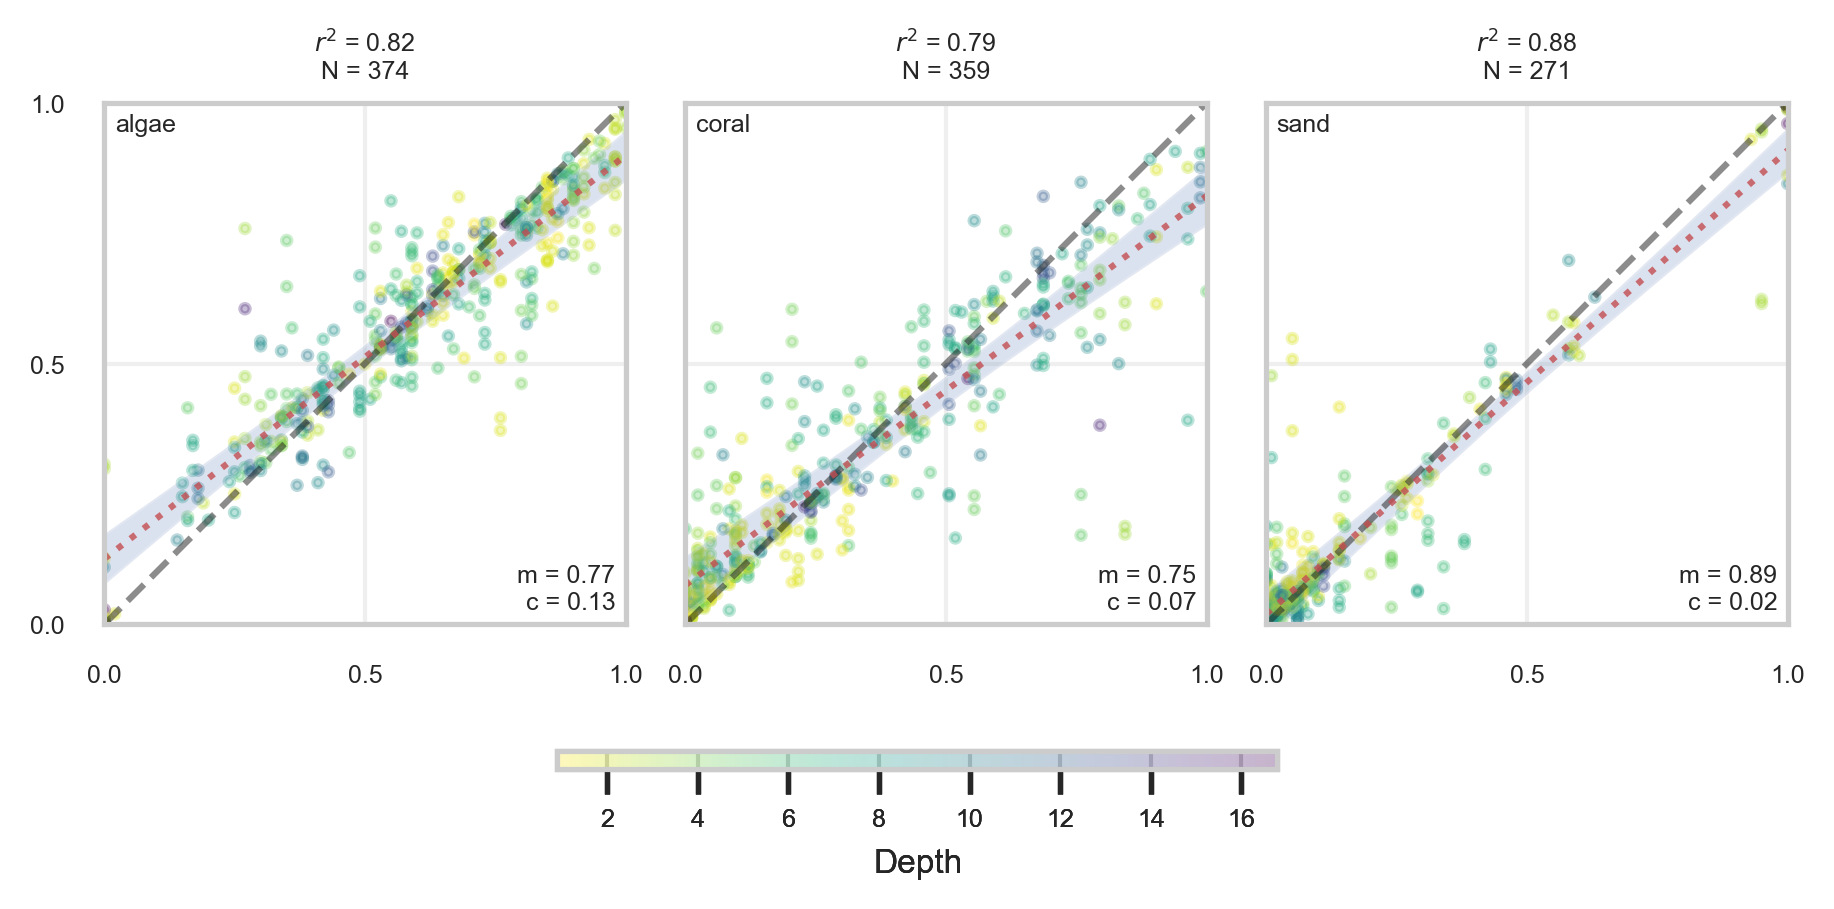

In [83]:
test_data = y_test
pred_data = best_rf_pca_5.predict(X_test_pca_5)

metadata = ml_utils.generate_model_metadata(validation_data, best_rf_pca_5, X_test_pca_5, test_data)
plotting.plot_regression_results(test_data, pred_data, test_data,
                                 metadata=metadata, color_by="Depth"
                                 )

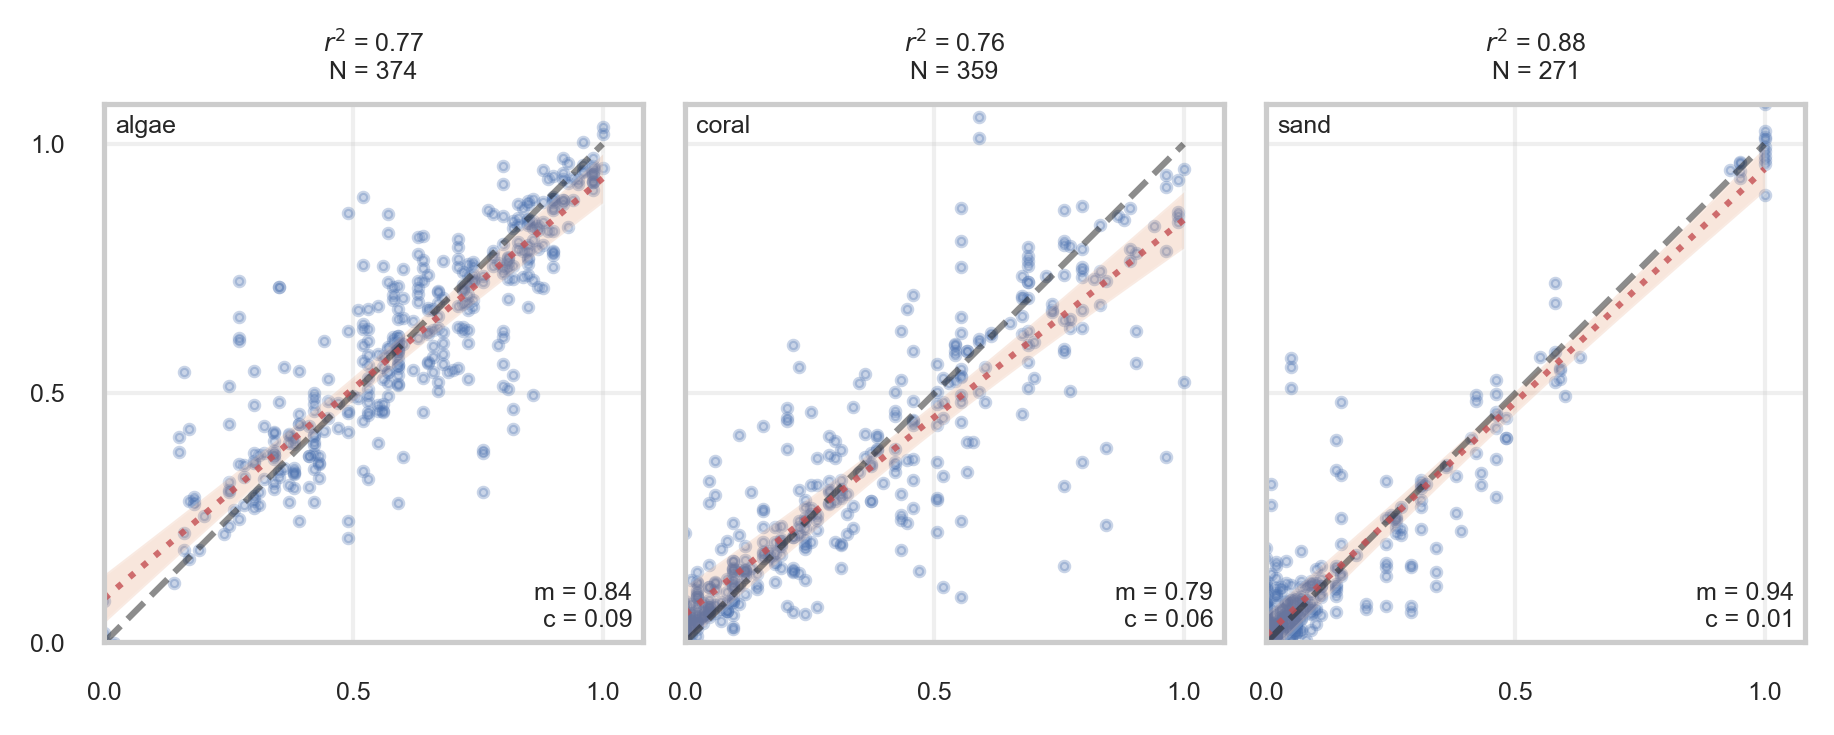

In [79]:
test_data = y_test
pred_data = best_mlp_pca_5.predict(X_test_pca_5)

plotting.plot_regression_results(test_data, pred_data, test_data,
                                #  metadata=metadata, color_by="Depth"
                                 )

spectra_vals = scene_xa.values.reshape(scene_xa.shape[0], -1)
wvs = scene_xa.coords["band"].values
test_spectra_df = pd.DataFrame(spectra_vals.T, columns=wvs).dropna(axis=0)
test_spectra_df
xa.open_dataset(file_ops.KANEOHE_HS_FP)
# ML
# load model
model_fp = file_ops.RESOURCES_DIR_FP / "models" / "20241001-151758" / "best_rf.pkl"
rf_model = joblib.load(model_fp)

# remove nans
no_nan_hs_vals = hs_vals.dropna()
no_nan_hs_vals

endmember_rf_inferred = ml_utils.infer_on_spatial(rf_model, scene_xa, ["algae", "coral", "sand"])
endmember_rf_inferred
# cmap = sns.color_palette("rocket", as_cmap=True)
# create cmap for coral: from transparent to coral colour
from matplotlib.colors import LinearSegmentedColormap
coral_hex = "#ff9b4f"
algae_hex = "#0f6300"
sand_hex = "#ffd608"

coral_cmap = LinearSegmentedColormap.from_list("coral", ["#00000000", coral_hex])
algae_cmap = LinearSegmentedColormap.from_list("algae", ["#00000000", algae_hex])
sand_cmap = LinearSegmentedColormap.from_list("sand", ["#00000000", sand_hex])

fig, ax = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)

pred_vars = [var for var in endmember_rf_inferred.data_vars if re.search(r'_pred$', var)]
min_values = [np.nanmin(endmember_rf_inferred[var].values) for var in pred_vars]
max_values = [np.nanmax(endmember_rf_inferred[var].values) for var in pred_vars]

for i, (var_cmap, var) in enumerate(zip([algae_cmap, coral_cmap, sand_cmap], ["algae_pred", "coral_pred", "sand_pred"])):
    im = endmember_rf_inferred[var].plot.imshow(ax=ax[i], cmap=var_cmap, add_colorbar=False, 
                                                # vmin=min(min_values), vmax=max(max_values)
                                                )
    ax[i].text(
        0.98, 0.98, var, transform=ax[i].transAxes, ha='right', va='top',
    )
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_yticklabels([])
    ax[i].set_aspect('equal')
    fig.colorbar(im, ax=ax[i], orientation='horizontal', fraction=0.03, pad=0.04)

fig.text(0.5, 0.0, 'Longitude', ha='center')
fig.text(0, 0.5, 'Latitude', va='center', rotation='vertical')

fig.tight_layout()
# mask depth
depth_trained_model = joblib.load(file_ops.MODELS_DIR_FP / "20241004-132443/best_mlp_depth_no_kaneohe.pkl")
depth_mlp_inferred = ml_utils.infer_on_spatial(depth_trained_model, scene_xa, ["depth"])

# scale depth values according to validation data
depth_mlp_inferred["depth_pred"] = depth_mlp_inferred["depth_pred"] * np.max(validation_data.Depth)
depth_mlp_inferred
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
depth_mlp_inferred["depth_pred"].plot.imshow(ax=ax, add_colorbar=True, cmap="Blues"
                                                # vmin=min(min_values), vmax=max(max_values)
                                                )
# depth-mask benthic classifications
masked_endmember_rf_inferred = endmember_rf_inferred.where(depth_mlp_inferred["depth_pred"] <= 7, np.nan)

fig, ax = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)

pred_vars = [var for var in masked_endmember_rf_inferred.data_vars if re.search(r'_pred$', var)]
min_values = [np.nanmin(masked_endmember_rf_inferred[var].values) for var in pred_vars]
max_values = [np.nanmax(masked_endmember_rf_inferred[var].values) for var in pred_vars]

for i, (var_cmap, var) in enumerate(zip([algae_cmap, coral_cmap, sand_cmap], ["algae_pred", "coral_pred", "sand_pred"])):
    im = masked_endmember_rf_inferred[var].plot.imshow(ax=ax[i], cmap=var_cmap, add_colorbar=False, 
                                                # vmin=min(min_values), vmax=max(max_values)
                                                )
    ax[i].text(
        0.98, 0.98, var, transform=ax[i].transAxes, ha='right', va='top',
    )
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_yticklabels([])
    ax[i].set_aspect('equal')
    fig.colorbar(im, ax=ax[i], orientation='horizontal', fraction=0.03, pad=0.04)

fig.text(0.5, 0.0, 'Longitude', ha='center')
fig.text(0, 0.5, 'Latitude', va='center', rotation='vertical')

fig.tight_layout()
# Interpreting ML

from sklearn.inspection import PartialDependenceDisplay

(X_train_benthic, X_test_benthic), (y_train_benthic, y_test_benthic), labels = ml_utils.MLDataPipe(
    endmember_class_schema="three_endmember", target="endmember", data_source="prism_fits").generate_data()

features = [0,10,20]

PartialDependenceDisplay.from_estimator(rf_model, X_train_benthic, features, kind="individual")
# show route through ensemble
